# Online Shoppers Purchasing Intention Analysis
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

# STEP 0 : Importing libraries and files

In [129]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn import decomposition
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Importing the dataset
data = pd.read_csv("online_shoppers_intention.csv", header = 0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# STEP 1 : Data Cleaning (if necessary)

In [130]:
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [131]:
print(data['Month'].value_counts())
print(data['VisitorType'].value_counts())

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64


# STEP 2 : Data preprocessing

In [132]:
#Encoding Categorical features
column_trans = make_column_transformer((OneHotEncoder(),['Month','OperatingSystems','Browser','VisitorType','Weekend']),remainder='passthrough')

#Purchased
dataset_p = data[data.Revenue==True]
#Not Purchased
dataset_np = data[data.Revenue==False]

#Downsampled Dataset
dataset_p_down = resample(dataset_p,replace=False,n_samples=1000)
dataset_np_down = resample(dataset_np,replace=False,n_samples=5000)
dataset = pd.concat([dataset_p_down,dataset_np_down])

# Identifying the class label
X = dataset.drop(columns=['Revenue'])
column_trans.fit(X)
X = column_trans.transform(X)
scalar = MinMaxScaler()
scalar.fit(X)
y = dataset['Revenue']

# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

# Center and normalize the data
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

# STEP 3 : Data Visualisation

## Features correlation matrix

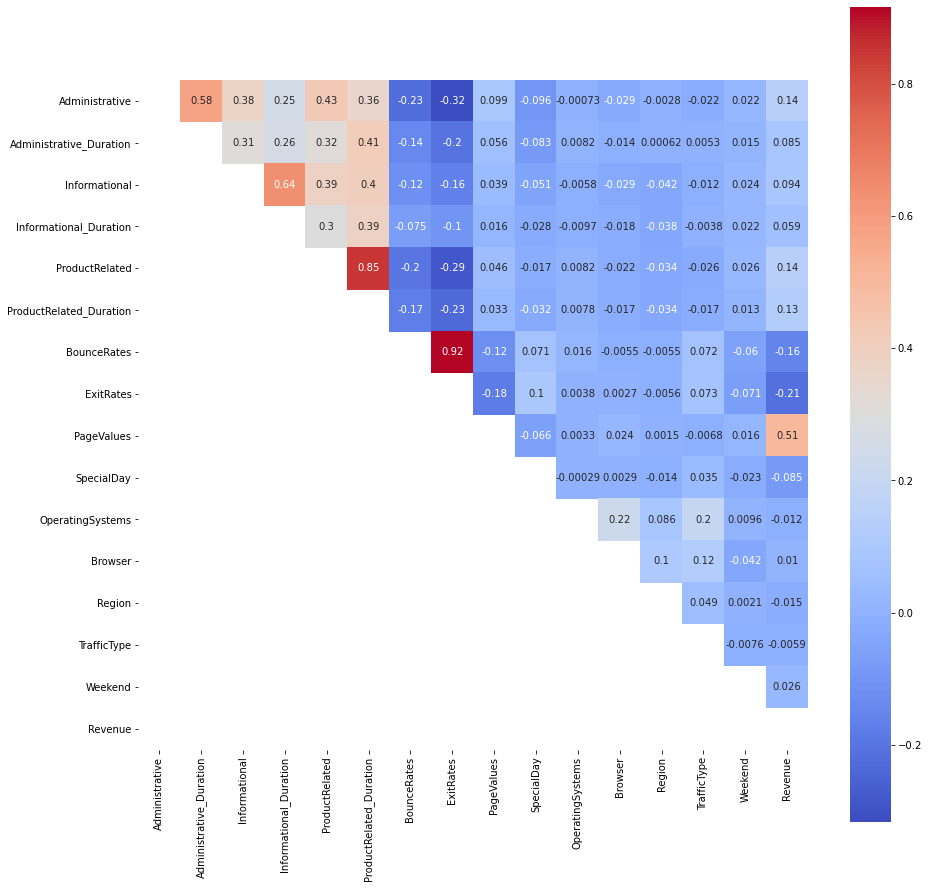

In [133]:
plt.subplots(figsize=(15,15))
matrix = np.tril(data.corr())
sns.heatmap(dataset.corr(), annot = True, cmap= 'coolwarm',square=True,mask = matrix)

## Principal Component Analysis

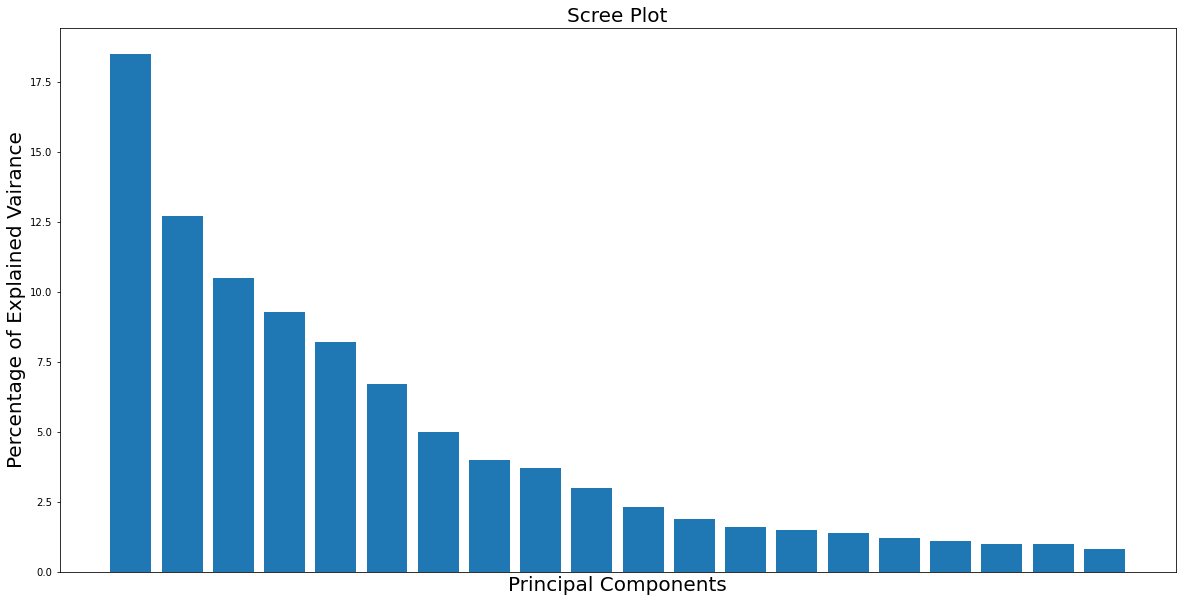

In [134]:
#Showing the first 20 most important axes
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
labels = [str(x) for x in range(1,len(per_var)+1)]
plt.rcParams['figure.figsize'] = (20, 10)
font=20
plt.bar(x=range(1,len(per_var)+1),height=per_var)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel('Percentage of Explained Vairance', fontsize = font)
plt.xlabel('Principal Components', fontsize = font)
plt.title('Scree Plot', fontsize = font)
plt.show()

## 2D PCA Plot

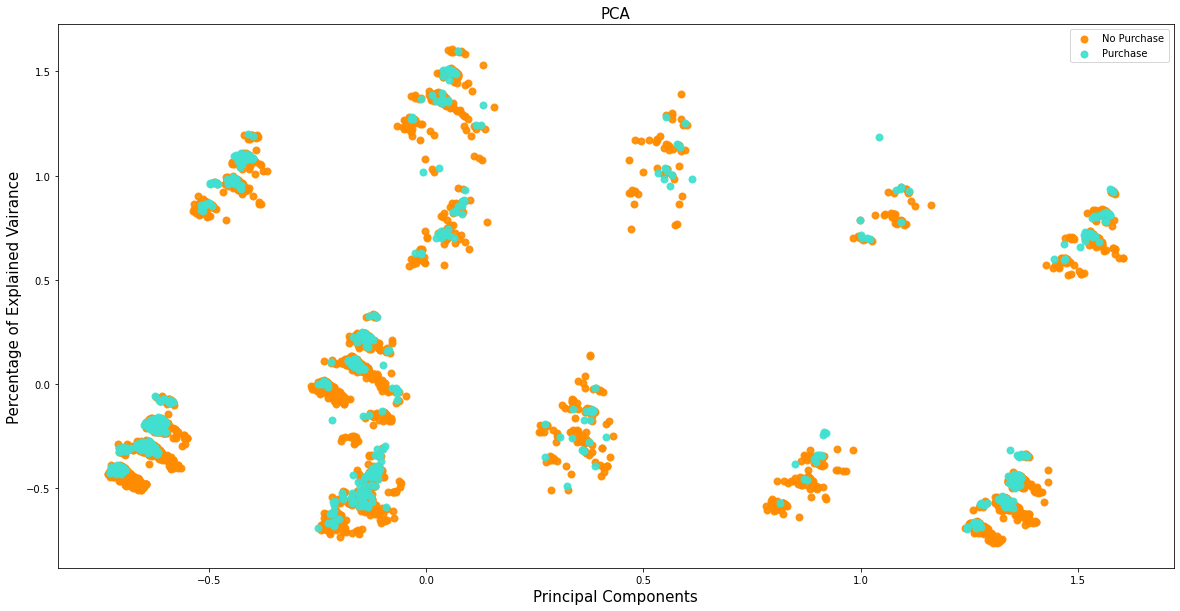

In [135]:
X_r = pca.fit(X_train).transform(X_train)

plt.figure()

colors = ['darkorange', 'turquoise']
lw = 2

target_names= ["No Purchase","Purchase"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, alpha=.9, lw=lw,
                label=target_name)
plt.rcParams['figure.figsize'] = (10, 5)
font=15
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA',fontsize=font)
plt.ylabel('Percentage of Explained Vairance',fontsize=font)
plt.xlabel('Principal Components',fontsize=font)

plt.show()

## Univariate Analysis

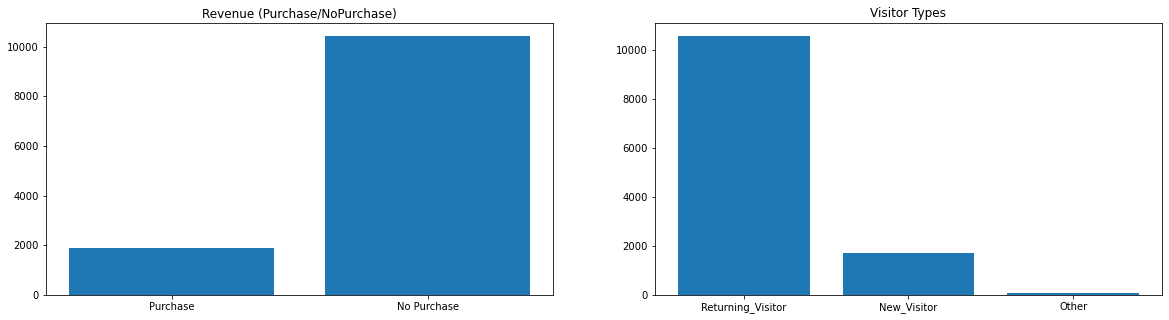

In [136]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,5)

#Visitor Types
axs[1].set_title("Visitor Types")
Vtype = ['Returning_Visitor','New_Visitor','Other']
count_vtype = [data['VisitorType'].value_counts()['Returning_Visitor'],
               data['VisitorType'].value_counts()['New_Visitor'],
               data['VisitorType'].value_counts()['Other']]
axs[1].bar(Vtype,count_vtype)

#Number of Purchased
axs[0].set_title("Revenue (Purchase/NoPurchase)")
TF = ["Purchase","No Purchase"]
TF_count = [data['Revenue'].value_counts()[True],data['Revenue'].value_counts()[False]]
axs[0].bar(TF,TF_count)

plt.show()

Text(0.5, 1.0, 'Number of Purchase each month')

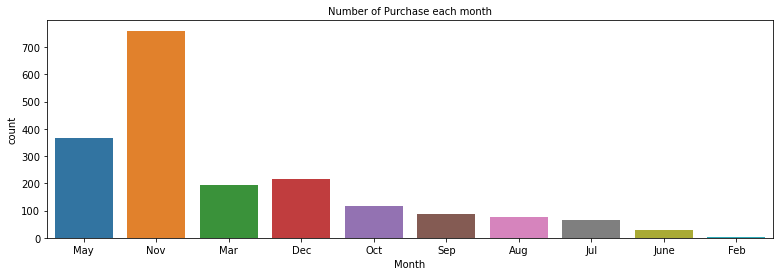

In [137]:
plt.figure(figsize=(13, 4))
sns.countplot(dataset_p.Month.dropna(), order = data.Month.value_counts().index);
plt.title('Number of Purchase each month', fontsize = 10)

Text(0.5, 1.0, 'Number of No Purchase each month')

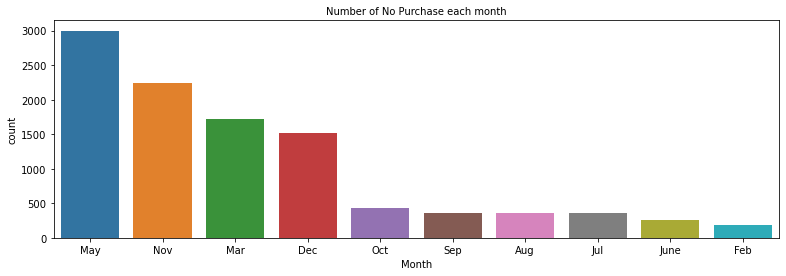

In [138]:
plt.figure(figsize=(13, 4))
sns.countplot(dataset_np.Month.dropna(), order = data.Month.value_counts().index);
plt.title('Number of No Purchase each month', fontsize = 10)

## Bivariate analysis

### Exit rate by Revenue (Purchase/NoPurchase)

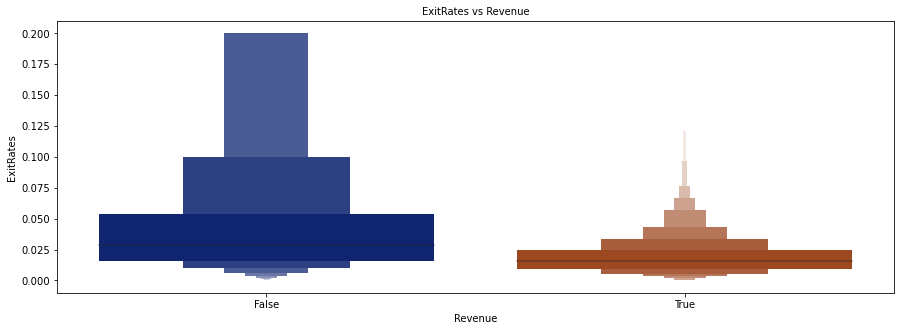

In [139]:
# product related duration vs revenue

plt.rcParams['figure.figsize'] = (15, 5)
# exit rate vs raevenue
sns.boxenplot(data['Revenue'], data['ExitRates'], palette = 'dark')
plt.title('ExitRates vs Revenue', fontsize = 10)
plt.xlabel('Revenue', fontsize = 10)
plt.ylabel('ExitRates', fontsize = 10)

plt.show()

### Revenue by visitor type

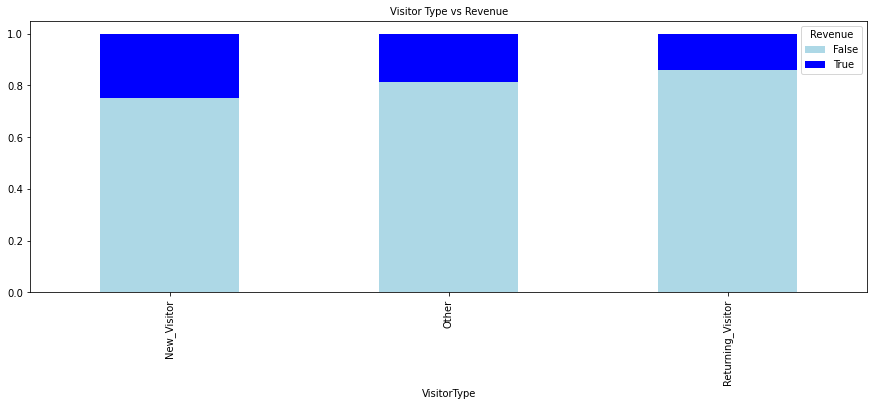

In [140]:
df = pd.crosstab(data['VisitorType'], data['Revenue'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['lightblue', 'blue'])
plt.title('Visitor Type vs Revenue', fontsize = 10)
plt.show()

## Multivariate analysis

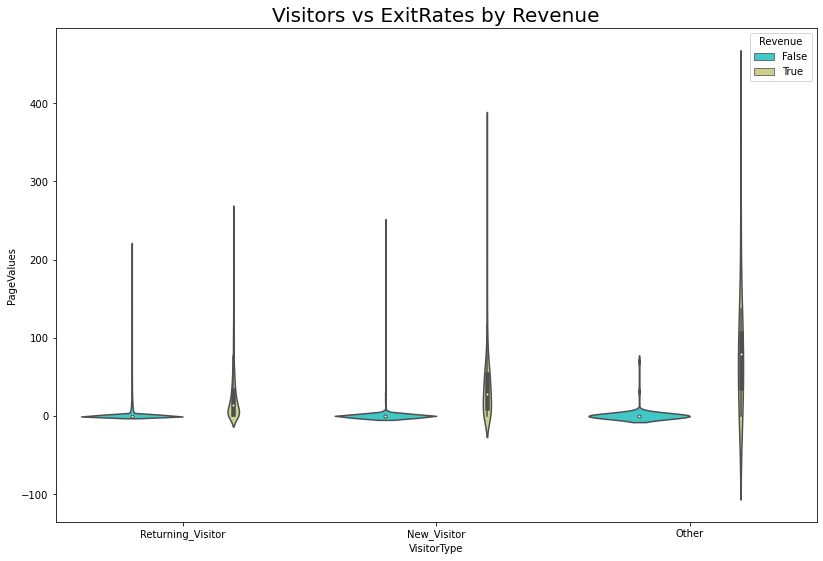

In [141]:
plt.rcParams['figure.figsize'] = (30, 20)
plt.subplot(2, 2, 1)
sns.violinplot(x = data['VisitorType'], y = data['PageValues'], hue = data['Revenue'], palette = 'rainbow')
plt.title('Visitors vs ExitRates by Revenue', fontsize = 20)

plt.show()

# STEP 4: Building ML Model

## Overview of a few model's performance

Naive Bayes 
 Accuracy: 0.26866666666666666 
 f1 score 0.30613535736875397
Logistic Regression 
 Accuracy: 0.8746666666666667 
 f1 score 0.42682926829268286


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K Nearest Neighbour 
 Accuracy: 0.8313333333333334 
 f1 score 0.2402402402402402
Support Vector Classification 
 Accuracy: 0.856 
 f1 score 0.22302158273381295
Decision Tree Classification 
 Accuracy: 0.8613333333333333 
 f1 score 0.5536480686695279
Stochastic Gradient Descent 
 Accuracy: 0.8826666666666667 
 f1 score 0.49714285714285716
Linear Discriminant Analysis 
 Accuracy: 0.8806666666666667 
 f1 score 0.5068870523415978
Gradient Boosting Classification  
 Accuracy: 0.8953333333333333 
 f1 score 0.6439909297052154
Random Forest Classification 
 Accuracy: 0.8986666666666666 
 f1 score 0.6161616161616162


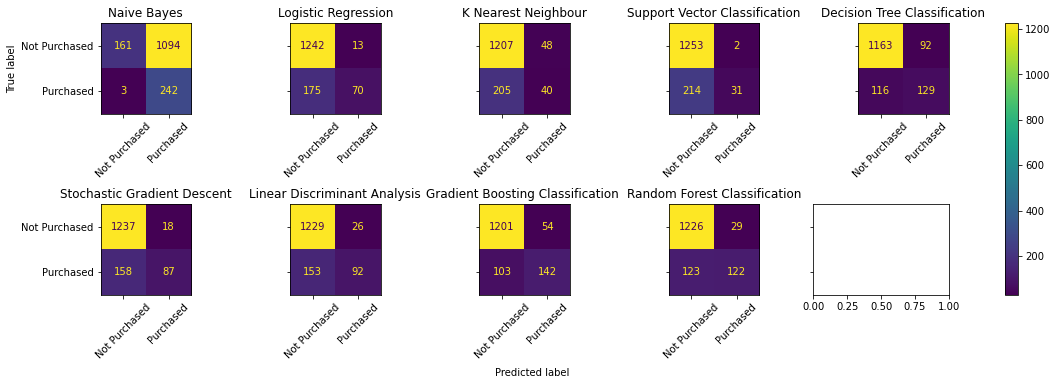

In [142]:
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "K Nearest Neighbour": KNeighborsClassifier(),
    "Support Vector Classification": SVC(),
    "Decision Tree Classification": DecisionTreeClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Gradient Boosting Classification ": GradientBoostingClassifier(),
    "Random Forest Classification": RandomForestClassifier()
    }

f, axes = plt.subplots(2, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    j = 0
    k = i
    if i>4:
        k = i-5
        j+=1
    
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(key, "\n Accuracy:",accuracy_score(y_test,y_pred),"\n f1 score",f1_score(y_test,y_pred))
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=["Not Purchased","Purchased"])
    disp.plot(ax=axes[j][k], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.43, -0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=1)


f.colorbar(disp.im_, ax=axes)
plt.show()

# STEP 3 : Model Tuning (Grid Search)

## Gradient Boosting

In [126]:
parameters = [{
    "loss":["deviance"],
    "learning_rate": [0.2,0.3,0.4],
    "min_samples_split": [0.01,0.1, 0.5],
    "min_samples_leaf": [0.0001,0.001, 0.01],
    "max_depth":[8,10,15],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.7,0.8,0.9],
    "n_estimators":[10,20,30]
    }]
gbm = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1,scoring='f1', verbose=True)
gbm.fit(X_train,y_train)


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1602 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 3002 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 4802 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 7002 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 8672 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 9522 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 10472 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 11522 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 12672 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 13922 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 14580 out of 14580 | elapsed: 26.1min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['friedman_mse', 'mae'],
                          'learning_rate': [0.2, 0.3, 0.4],
                          'loss': ['deviance'], 'max_depth': [8, 10, 15],
                          'max_features': ['log2', 'sqrt'],
                          'min_samples_leaf': [0.0001, 0.001, 0.01],
                          'min_samples_split': [0.01, 0.1, 0.5],
                          'n_estimators': [10, 20, 30],
                          'subsample': [0.7, 0.8, 0.9]}],
             scoring='f1', verbose=True)

In [143]:
print(gbm.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.1, 'n_estimators': 30, 'subsample': 0.7}


In [144]:
# Gradient boosting with best parameters
gs_gbm = GradientBoostingClassifier( 
    criterion='friedman_mse',
    learning_rate=0.3,
    loss='deviance',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf= 0.001,
    min_samples_split= 0.1,
    n_estimators = 20,
    subsample = 0.8
)
gs_gbm.fit(X_train, y_train)
gs_gbm.score(X_test,y_test)

0.8966666666666666

## Stochastic gradient descent

In [145]:
parameters = [{
    "max_iter": [100,200,300],
    "loss": ["hinge","log","squared_hinge","perceptron"],
    "penalty": ["elasticnet", "l1", "l2"],
    "alpha": [0.0001, 0.001, 0.01, 0.1], 
    "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
    "class_weight": [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
    "eta0": [1, 10] 
             }]
sgd = GridSearchCV(SGDClassifier(), parameters, cv=5, n_jobs=-1,scoring='f1', verbose=True)
sgd.fit(X_train,y_train)


Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 3462 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 6262 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 9862 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 14544 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 22580 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 23040 out of 23040 | elapsed:  2.7min finished


GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1],
                          'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.6, 1: 0.4},
                                           {0: 0.4, 1: 0.6}, {0: 0.3, 1: 0.7}],
                          'eta0': [1, 10],
                          'learning_rate': ['constant', 'optimal', 'invscaling',
                                            'adaptive'],
                          'loss': ['hinge', 'log', 'squared_hinge',
                                   'perceptron'],
                          'max_iter': [100, 200, 300],
                          'penalty': ['elasticnet', 'l1', 'l2']}],
             scoring='f1', verbose=True)

In [146]:
print(sgd.best_params_)

{'alpha': 0.001, 'class_weight': {1: 0.6, 0: 0.4}, 'eta0': 10, 'learning_rate': 'adaptive', 'loss': 'perceptron', 'max_iter': 200, 'penalty': 'elasticnet'}


In [ ]:
# Stochastic gradient descent with best parameters
gs_sgd = SGDClassifier(alpha =0.001, 
                       class_weight ={1: 0.7, 0: 0.3}, 
                       eta0 =1, 
                       learning_rate = 'optimal', 
                       loss= 'hinge', 
                       max_iter=10000000, 
                       penalty= 'l2')
gs_sgd.fit(X_train, y_train)
gs_sgd.score(X_test,y_test)

## Random Forest

In [ ]:
parameters = [{
    "criterion": ["gini",  "entropy"],
    "n_estimators": [200,400,600,800,1000],
    "max_features": ['auto', 'sqrt'],
    "max_depth": [5, 50, 100],
    "min_samples_split": [5,10,15,20,25,30], 
    "min_samples_leaf": [1,5,10,15,20],
    "bootstrap": [True, False]
             }]

rf = GridSearchCV(RandomForestClassifier(), 
                  parameters, 
                  cv=5, 
                  n_jobs=-1,
                  scoring='f1', 
                  verbose=True)

rf.fit(X_train,y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1238 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1788 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2438 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 4038 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 4988 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 6038 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 7188 tasks      | elapsed: 32.0min


In [ ]:
print(rf.best_params_)

In [ ]:
# Random forest with best parameters
gs_rf = RandomForestClassifier(bootstrap=False,
                               criterion='entropy',
                               max_depth= 50, 
                               max_features='sqrt', 
                               min_samples_leaf=1, 
                               min_samples_split=25, 
                               n_estimators=400)
gs_rf.fit(X_train, y_train)
gs_rf.score(X_test,y_test)

## Decision Tree

In [ ]:
parameters = [{
    "criterion": ['gini','entropy'],
    "max_depth": range(1,10),
    "min_samples_split": range(1,10), 
    "min_samples_leaf": [1,2,5,10],
             }]

dt = GridSearchCV(DecisionTreeClassifier(),
                  parameters, 
                  cv=5, n_jobs=-1,
                  scoring='f1', 
                  verbose=True)

dt.fit(X_train,y_train)

In [ ]:
print(dt.best_params_)

In [ ]:
# Decision Tree with best parameters
gs_dt = DecisionTreeClassifier(criterion='gini', 
                               max_depth= 4, 
                               min_samples_leaf=1, 
                               min_samples_split=2,)
gs_dt.fit(X_train, y_train)
gs_dt.score(X_test,y_test)

# STEP 4 : Ensemble Model Building

In [ ]:
# Side by side comparison with the 4 best performing classifiers

classifiers = {
    "Gradient Boosting": gs_gbm,
    "Stochastic Gradient Descent": gs_sgd,
    "Random Forest": gs_rf,
    "Decision Tree": gs_dt
}

f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(key, " \n Accuracy:",accuracy_score(y_test,y_pred),"\n f1 score",f1_score(y_test,y_pred))
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=["Not Purchased","Purchased"])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
# Combination of the two best models

from sklearn.ensemble import VotingClassifier
estimators=[('Random Forest',gs_rf),('Decision Tree',gs_dt)]
ensemble = VotingClassifier(estimators, voting='hard')

ensemble.fit(X_train, y_train)

y_pred = ensemble.fit(X_train, y_train).predict(X_test)
print(" Accuracy : ",accuracy_score(y_test,y_pred),"\n f1 score",f1_score(y_test,y_pred))

# STEP 5 : Export

## Exporting files for the API

In [ ]:
import pickle
pickle.dump(ensemble, open('Flask_restful_api/model.pickle', 'wb'))
pickle.dump(scalar, open('Flask_restful_api/scaler.pickle','wb'))
pickle.dump(column_trans, open('Flask_restful_api/column_trans.pickle','wb'))